In [77]:
"""
تحليل المناطق الأفضل للاستثمار العقاري في دبي
الهدف: ترتيب المناطق حسب فرص الاستثمار بناءً على مؤشر مركب
"""

'\nتحليل المناطق الأفضل للاستثمار العقاري في دبي\nالهدف: ترتيب المناطق حسب فرص الاستثمار بناءً على مؤشر مركب\n'

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [79]:
df = pd.read_csv("C:/Users/tf/Desktop/مشروع 1/Data after cleaning/real_estate_tourism_merged.csv")

In [80]:
df['year_month'] = pd.to_datetime(df_clean['year_month'])
df['year'] = df_clean['year_month'].dt.year
df['month'] = df_clean['year_month'].dt.month

In [81]:
# حساب مؤشر الاستثمار المركب

investment_scores = []
for area in df['area_name_en'].unique():
    area_data = df[df_clean['area_name_en'] == area]

    if len(area_data) < 12:
        continue

    # نمو السياحة
    tourism_growth = 0
    if len(area_data) >= 24:
        recent = area_data[area_data['year'] >= 2022]['tourism_activity'].mean()
        old = area_data[area_data['year'] < 2022]['tourism_activity'].mean()
        if old > 0:
            tourism_growth = ((recent - old) / old) * 100

    # استقرار الأسعار
    price_stability = 0
    price_std = area_data['avg_meter_price'].std()
    price_mean = area_data['avg_meter_price'].mean()
    if price_mean > 0:
        price_stability = 100 * (1 - price_std / price_mean)

    # السيولة
    liquidity = area_data['transactions_count'].sum() / len(area_data)

    # مستوى السياحة الحالي
    current_tourism = area_data['tourism_activity'].mean()
    tourism_percentile = (
        (current_tourism - df['tourism_activity'].min()) /
        (df_clean['tourism_activity'].max() - df_clean['tourism_activity'].min())
    ) * 100

    # جاذبية السعر
    price_attractiveness = 0
    overall_mean_price = df['avg_meter_price'].mean()
    area_mean_price = area_data['avg_meter_price'].mean()
    if overall_mean_price > 0:
        price_attractiveness = max(0, 100 * (1 - area_mean_price / overall_mean_price))

    # المؤشر المركب
    composite_score = (
        min(max(tourism_growth, -50), 100) * 0.30 +
        max(price_stability, 0) * 0.25 +
        min(liquidity * 10, 100) * 0.20 +
        tourism_percentile * 0.15 +
        price_attractiveness * 0.10
    )

    investment_scores.append({
        'Area': area,
        'Investment Score': round(composite_score, 2),
        'Tourism Growth %': round(tourism_growth, 2),
        'Price Stability %': round(price_stability, 2),
        'Monthly Liquidity': round(liquidity, 2),
        'Tourism Level': round(current_tourism, 2),
        'Avg Meter Price': round(area_mean_price, 2),
        'Months': len(area_data),
        'Transactions': int(area_data['transactions_count'].sum())
    })

scores_df = pd.DataFrame(investment_scores)

if scores_df.empty:
    print("No valid areas for scoring")
    exit()

scores_df = scores_df.sort_values('Investment Score', ascending=False)
print("Investment scoring completed")


Investment scoring completed


In [82]:
# تصنيف الاستثمار
def classify(score):
    if score >= 70:
        return "Excellent"
    elif score >= 60:
        return "Very Good"
    elif score >= 50:
        return "Good"
    elif score >= 40:
        return "Average"
    else:
        return "Weak"

scores_df['Rating'] = scores_df['Investment Score'].apply(classify)

In [83]:
# تحليل فئات السعر
price_bins = [0, 5000, 10000, 20000, 50000, float('inf')]
price_labels = ['Low', 'Medium', 'High', 'Very High', 'Luxury']
scores_df['Price Segment'] = pd.cut(scores_df['Avg Meter Price'],bins=price_bins,labels=price_labels)

In [84]:
# تحديد الفرص الخاصة
emerging_areas = scores_df[
    (scores_df['Tourism Growth %'] > 20) &
    (scores_df['Avg Meter Price'] < df['avg_meter_price'].mean())
]

stable_areas = scores_df[
    (scores_df['Price Stability %'] > 80) &
    (scores_df['Monthly Liquidity'] > 3)
]

print(f"Emerging areas: {len(emerging_areas)} | Stable areas: {len(stable_areas)}")

Emerging areas: 28 | Stable areas: 3


Text(0.5, 1.0, 'Investment Rating Distribution')

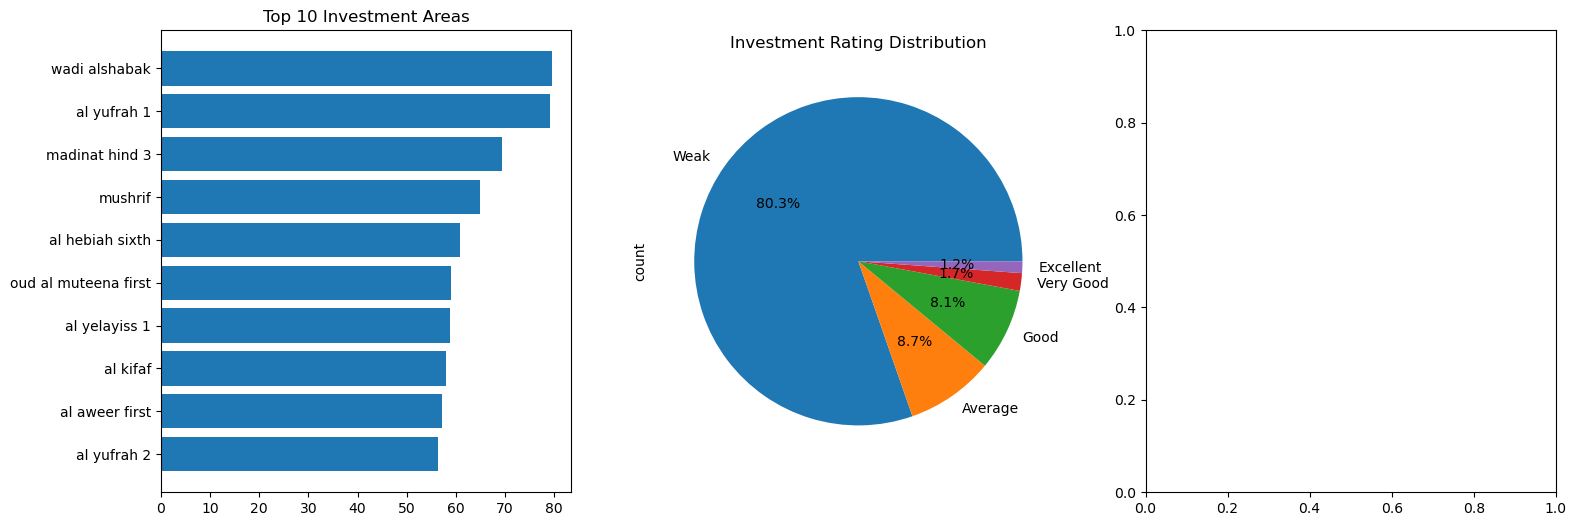

In [85]:
#  المخططات البيانية
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

top_10 = scores_df.head(10)
axes[0].barh(top_10['Area'], top_10['Investment Score'])
axes[0].set_title('Top 10 Investment Areas')
axes[0].invert_yaxis()

scores_df['Rating'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    ax=axes[1]
)
axes[1].set_title('Investment Rating Distribution')

scatter = axes[2].scatter(
    scores_df['Avg Meter Price'],
    scores_df['Investment Score'],
    c=scores_df['Tourism Growth %'],
    cmap='RdYlGn',
    alpha=0.6
)
axes[2].set_xlabel('Avg Meter Price')
axes[2].set_ylabel('Investment Score')
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[2], label='Tourism Growth %')

plt.tight_layout()
